In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if False:
    import os
    # Turn off GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    gpu = False
else:
    gpu = True

In [2]:
from tensorflow import keras
from copy import deepcopy
import tensorflow as tf
from glob import glob
import numpy as np
import os

import models
from modelclass import Model

gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpu:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024 * 2))])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from utils.cityscapesSequence import CitySequence

GENERAL_PATH = os.path.join("model-saved", "model-1", "city")
MODEL_NAME = "city_best_model-1.hdf5"
MODEL_PATH = os.path.join(GENERAL_PATH, MODEL_NAME)

image_size = 256
batch_size = 2
alpha = 1.

In [4]:
def cityDataset(batch_size=1, catId=False, binary=False):
    DATA_DIR = "../cityscapes"
    DATA_TYPE = "gtFine"

    TYPE = "train"
    x_train_dir = sorted(glob(os.path.join(
        DATA_DIR, DATA_TYPE, "leftImg8bit", TYPE, "*/*_leftImg8bit.png")))
    y_train_dir = sorted(glob(os.path.join(
        DATA_DIR, DATA_TYPE, "gtFine", TYPE, "*/*_labelIds.png")))

    TYPE = "val"
    x_val_dir = sorted(glob(os.path.join(DATA_DIR, DATA_TYPE,
                                         "leftImg8bit", TYPE, "*/*_leftImg8bit.png")))
    y_val_dir = sorted(glob(os.path.join(DATA_DIR, DATA_TYPE,
                                         "gtFine", TYPE, "*/*_labelIds.png")))
    print(len(x_val_dir))

    x_train = CitySequence(x_dir=x_train_dir, y_dir=y_train_dir, batch_size=batch_size, blur=0,
                        image_size=image_size, horizontal_flip=True, vertical_flip=False,
                        brightness=0.1, contrast=0, crop=True, catId=catId, binary=binary)
    x_val = CitySequence(x_dir=x_val_dir, y_dir=y_val_dir, batch_size=batch_size, blur=0,
                         image_size=image_size, horizontal_flip=False, vertical_flip=False,
                         brightness=0, contrast=0, crop=False, catId=catId, binary=binary)
    print(len(x_train_dir), len(y_train_dir), x_train.x_y_len)
    print(len(x_val_dir), len(y_val_dir), x_val.x_y_len)
    print(x_train.num_classes)

    return x_train, x_val

In [5]:
from seaborn import color_palette, heatmap
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from copy import deepcopy
import numpy as np


def colorPalette(num_classes):
    colorList = color_palette(None, num_classes)
    colorListAux = []

    for i in colorList:
        colorListAux.append(int(i[0] * 255))
        colorListAux.append(int(i[1] * 255))
        colorListAux.append(int(i[2] * 255))
    colorList = None
    return colorListAux

def mIOU(model, img, true_mask):
    mask = model.predict(img[None, :, :, :])[0].astype(np.uint8)

    ulabels = np.unique(true_mask)[:-1]

    iou = np.zeros(len(ulabels))

    for k, u in enumerate(ulabels):
        inter = (true_mask == u) & (mask == u)
        union = (true_mask == u) | (mask == u)

        iou[k] = inter.sum() / union.sum()

    # iou[k+1] = 1.
    return np.round(iou.mean(), 2)

def showInference(model, img, true_mask):
    miou = mIOU(model, img, true_mask)
    
    if len(np.unique(true_mask)) > 10:
        colorList = colorPalette("Spectral", len(np.unique(true_mask)))
    else:
        colorList = colorPalette(len(np.unique(true_mask)))

    img_2 = ((img + 1) * 255).astype(np.int16).astype(np.float32) / 2 / 255  # from [-1, 1] to [0, 1]

    true_mask = fromarray(true_mask.astype(np.uint8), mode="P")
    true_mask.putpalette(colorList)
    true_mask = true_mask.convert("RGB")
    true_mask = np.asarray(true_mask)

    mask = model.predict(img[None, :, :, :])[0].astype(np.uint8)
    print(mask.shape)
    print(np.unique(mask))
    mask = fromarray(mask, mode="P")
    mask.putpalette(colorList)
    mask = mask.convert("RGB")
    mask = np.asarray(mask)


    fig = plt.figure(figsize=(64, 64))

    plt.subplot(1, 4, 1)
    plt.imshow(img_2)
    plt.axis('off')
    plt.title("Image", fontdict = {'fontsize' : 50})

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask)
    plt.axis('off')
    plt.title("True mask", fontdict = {'fontsize' : 50})

    plt.subplot(1, 4, 3)
    plt.imshow(mask)
    plt.axis('off')
    plt.title(f"Predicted mask - {miou:.2f}", fontdict = {'fontsize' : 50})

    plt.subplot(1, 4, 4)
    plt.imshow(img_2)
    plt.imshow(mask, alpha=0.3)
    plt.axis('off')
    plt.title("Image + predicted mask", fontdict = {'fontsize' : 50})


def mIOU_all_images(model, x_val):  # Takes some time
    all_batchs_miou = 0

    for i in range(len(x_val)):  # Run over all batchs
        batch_miou = 0
        imgs, true_masks, _ = x_val.__getitem__(i)

        # Run over images inside the batch
        for img, true_mask in zip(imgs, true_masks):
            true_mask = np.reshape(true_mask[:, 0], (256, 256))
            miou = mIOU(model, img, true_mask)
            batch_miou += miou
            print(miou, end=" ")
        # sum(batch mIoU) / len(batch)
        all_batchs_miou += batch_miou / len(true_masks)

    # sum(all_batchs mIoU) / len(all_batchs)
    all_batchs_miou = all_batchs_miou / len(x_val)
    print()
    return np.round(all_batchs_miou, 2)
    
def getImageMask(x, i, j):
    """ Get the image and mask from the batch
        args:
            x: Sequence object
            i: the index of the batch_size (0 to batch_size - 1)
            j: the index of the __getitem__ (0 to len(x))
    """

    img, true_mask, _ = x.__getitem__(j)  # 0 to len(x)  # ((batch, size * size, 3), (batch, size * size, 1))
    img, true_mask = img[i], true_mask[i, :, 0]
    true_mask = np.reshape(true_mask, (256, 256))
    return img, true_mask

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix(model, x):
    def labels(y_pred, y_true):
        batch_size = y_pred.shape[0]

        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(batch_size):
            # True positive 1 & 1
            TP += np.bitwise_and(
                (y_true[i] == 1), (y_pred[i] == 1)).sum()
            # False positive 0 & 1
            FP += np.bitwise_and(
                (y_true[i] == 0), (y_pred[i] == 1)).sum()
            # True negative 0 & 0
            TN += np.bitwise_and(
                (y_true[i] == 0), (y_pred[i] == 0)).sum()
            # False negative 1 & 0
            FN += np.bitwise_and(
                (y_true[i] == 1), (y_pred[i] == 0)).sum()

        return [TP, FP, TN, FN]

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(x)):
        imgs, true_masks, _ = x.__getitem__(i)

        for img, true_mask in zip(imgs, true_masks):
            true_mask = np.reshape(true_mask[:, 0], (256, 256))
            y_pred = model.predict(img[None, :, :, :])[0].astype(np.uint8)
            labels_ = labels(true_mask, y_pred)

            TP += labels_[0]
            FP += labels_[1]
            TN += labels_[2]
            FN += labels_[3]

    heatmap([[TP, FP], [FN, TN]], annot=True,
             fmt='d', cmap='Blues',
             xticklabels=["True", "False"],
             yticklabels=["True", "False"])

In [6]:
x_train, x_val = cityDataset(catId=False, binary=True)
num_classes = x_val.num_classes
print(num_classes)

500
2975 2975 [2975, 2975]
500 500 [500, 500]
2
2


In [7]:
GENERAL_PATH = "model-saved/cityscapes"
MODEL_NAME = "binary_fog_rain.hdf5"
MODEL_PATH = os.path.join(GENERAL_PATH, MODEL_NAME)
model = models.deeplabV3(image_size=image_size, num_classes=num_classes, alpha=alpha, with_argmax=True)

model.load_weights(MODEL_PATH)

In [8]:
img, true_mask = getImageMask(x_val, 0, 0)

# plt.imshow(img)

(256, 256)
[0 1]


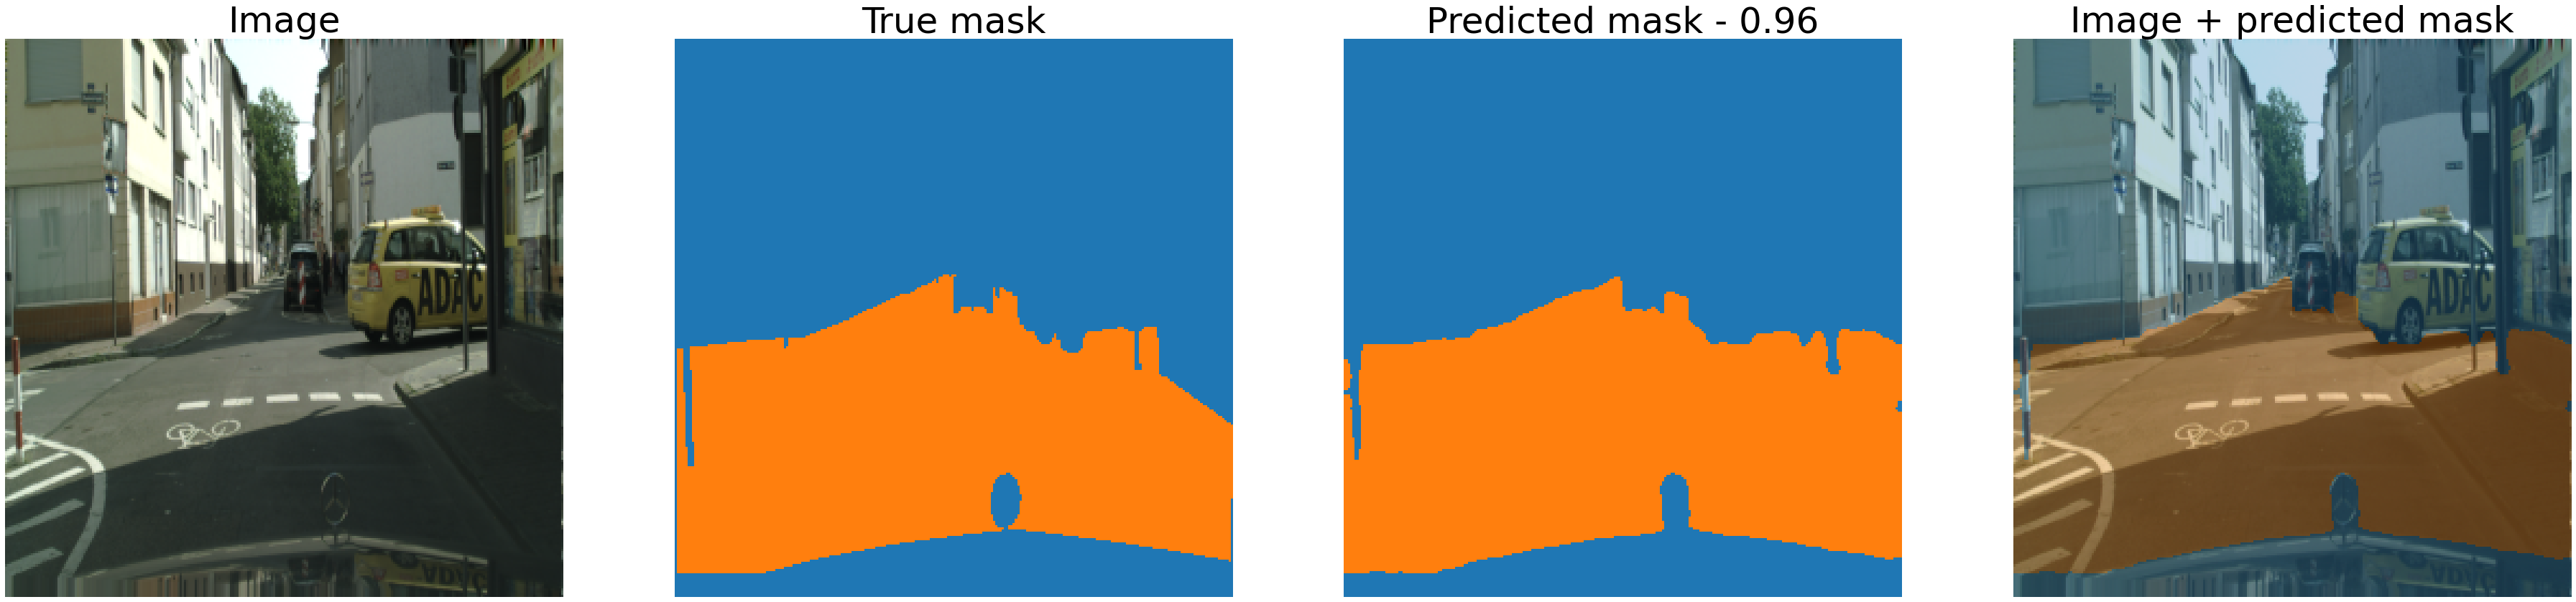

In [9]:
showInference(model, img, deepcopy(true_mask))
# print(mIOU(model, img, true_mask))

In [10]:
img, true_mask = getImageMask(x_val, 0, 5)

# plt.imshow(img)

(256, 256)
[0 1]


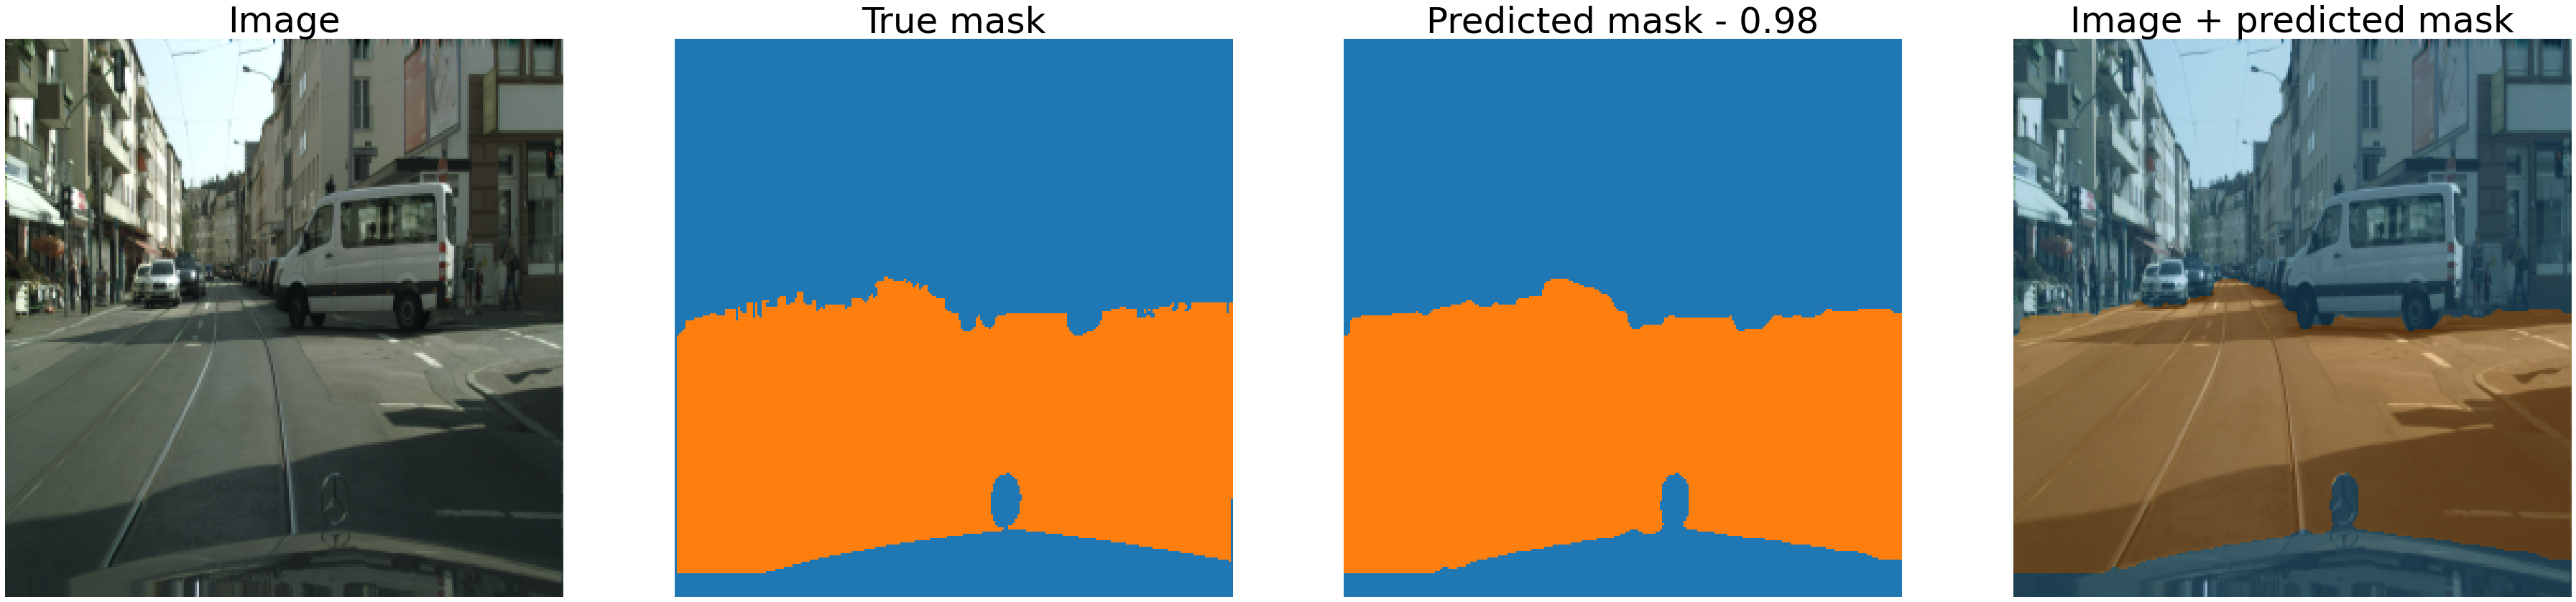

In [11]:
showInference(model, img, deepcopy(true_mask))
# print(mIOU(model, img, true_mask))

In [12]:
img, true_mask = getImageMask(x_val, 0, 15)

# plt.imshow(img)

(256, 256)
[0 1]


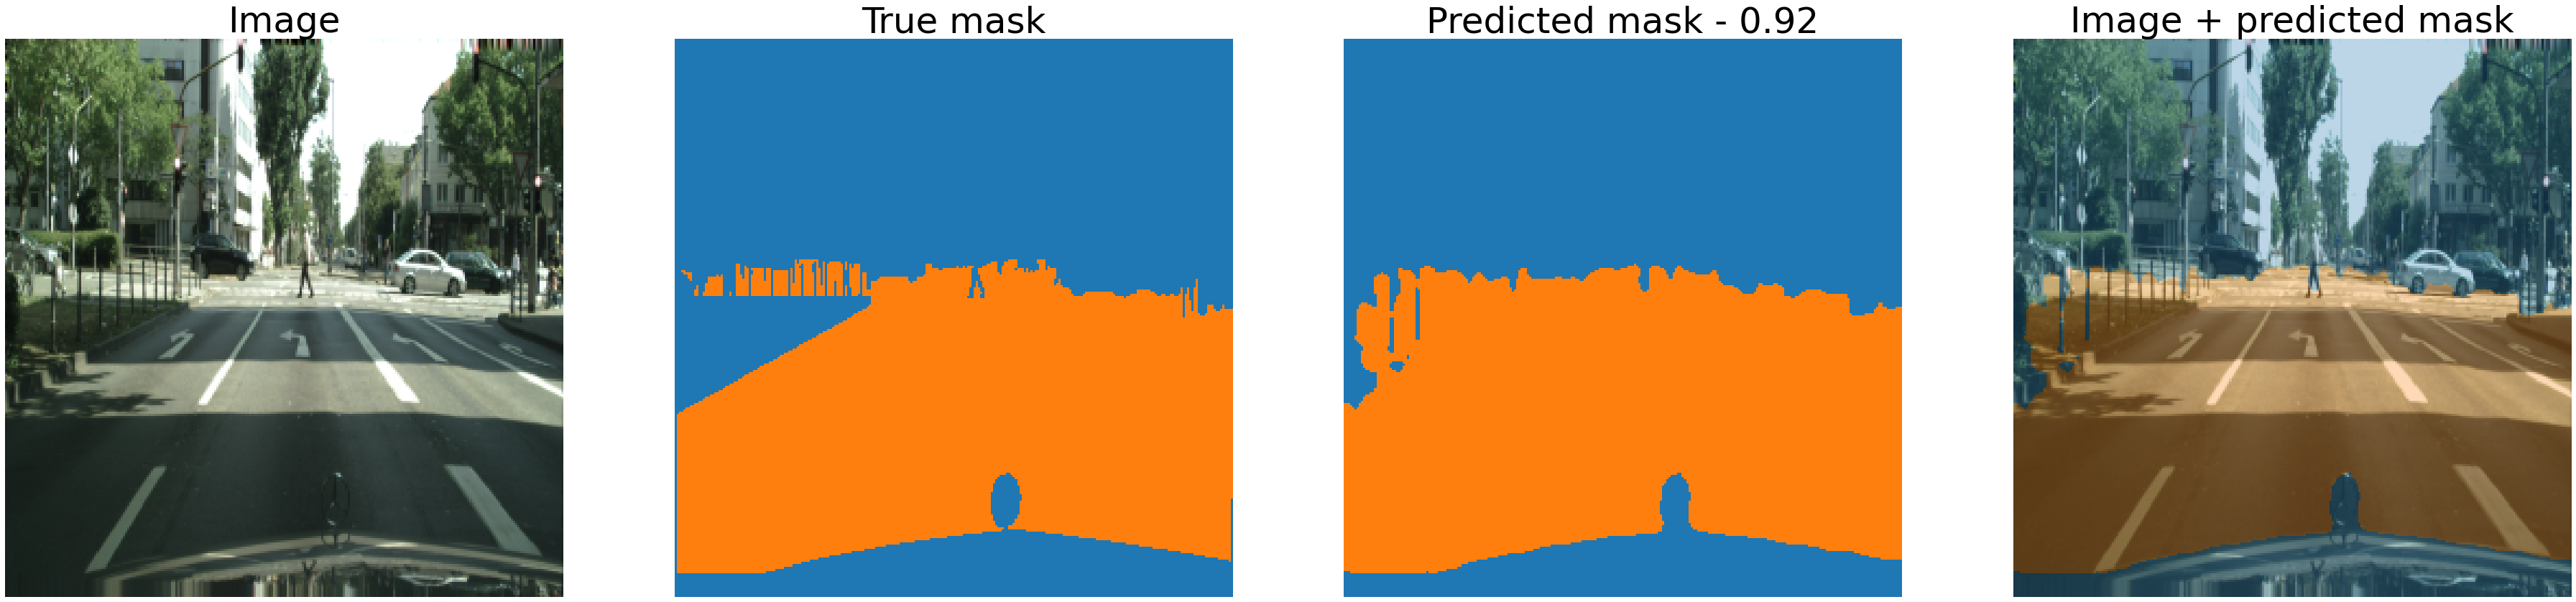

In [13]:
showInference(model, img, deepcopy(true_mask))
# print(mIOU(model, img, true_mask))

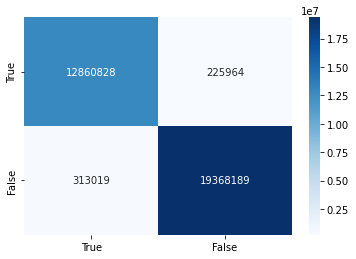

In [14]:
confusion_matrix(model, x_val)

In [15]:
mIOU_all_images(model, x_val)

0.96 0.98 0.96 0.98 0.99 0.98 0.98 0.97 0.97 0.96 0.9 0.97 0.98 0.9 0.98 0.92 0.98 0.98 0.98 0.99 0.99 0.97 0.96 0.97 0.97 0.97 0.96 0.98 0.96 0.98 0.97 0.98 0.98 0.97 0.96 0.97 0.98 0.97 0.97 0.98 0.98 0.98 0.97 0.98 0.97 0.98 0.97 0.99 0.97 0.98 0.98 0.97 0.89 0.97 0.98 0.97 0.98 0.98 0.97 0.97 0.93 0.96 0.97 0.97 0.92 0.98 0.96 0.95 0.96 0.98 0.98 0.98 0.98 0.98 0.98 0.96 0.98 0.98 0.96 0.97 0.96 0.97 0.97 0.98 0.97 0.96 0.95 0.98 0.97 0.97 0.97 0.98 0.96 0.97 0.99 0.98 0.96 0.98 0.93 0.96 0.96 0.97 0.97 0.97 0.98 0.98 0.98 0.98 0.97 0.98 0.98 0.97 0.97 0.95 0.97 0.97 0.98 0.98 0.93 0.97 0.95 0.98 0.97 0.97 0.97 0.89 0.98 0.98 0.97 0.99 0.98 0.96 0.98 0.98 0.98 0.98 0.97 0.97 0.88 0.98 0.97 0.97 0.96 0.97 0.96 0.98 0.96 0.96 0.92 0.96 0.98 0.98 0.93 0.96 0.97 0.98 0.97 0.98 0.96 0.98 0.97 0.96 0.97 0.96 0.98 0.98 0.98 0.98 0.98 0.99 0.98 0.99 0.98 0.98 0.88 0.93 0.93 0.98 0.98 0.99 0.98 0.98 0.97 0.98 0.98 0.98 0.97 0.97 0.98 0.98 0.97 0.97 0.97 0.97 0.96 0.96 0.97 0.96 0.97 0.97 0.

0.97